In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import requests

# A/B Test: New Payment Flow

##Introduction

During this experiment, a test group was offered a new payment flow on the website, while the control group continued using the old one.
The goal was to analyze the results and decide whether the new payment process should be rolled out to all users.


<br>**Steps:**
1. Data Processing & EDA
2. Defining key metrics
3. Statistical Analysis and Hypothesis Testing
4. Conclusion and Next Steps






## Data Processing


<br>Four datasets were provided for the analysis:

* `groups.csv` - shows which group each user belongs to (A - control, B - test)

* `groups_add.csv` - an additional batch of users shared two days later

* `active_studs.csv` - contains users who visited the platform during the experiment

* `checks.csv` - includes payment data for the experiment period




### Data Load
Load data and check for duplicates, missing values, consistency ans sample ratio mismatch.

In [2]:
#read the data
def yandex_read_csv(public_key, **arrgs):

    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    response = requests.get(api_url, params={"public_key": public_key})
    response.raise_for_status()

    download_url = response.json()["href"]

    return pd.read_csv(download_url, **arrgs)

In [3]:
gr_path = "https://disk.yandex.ru/d/UhyYx41rTt3clQ"
gr_a_path = "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ"
a_st_path = "https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ"
ch_path = "https://disk.yandex.ru/d/pH1q-VqcxXjsVA"

In [4]:
groups = yandex_read_csv(gr_path, sep = ";")
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.isna().sum()

,0
id,0
grp,0


In [6]:
groups.duplicated().sum()

np.int64(0)

In [7]:
groups.shape

(74484, 2)

In [8]:
groups_add = yandex_read_csv(gr_a_path)
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.isna().sum()

,0
id,0
grp,0


In [10]:
groups_add.duplicated().sum()

np.int64(0)

In [11]:
groups_add.shape

(92, 2)

In [12]:
active_studs = yandex_read_csv(a_st_path)
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
active_studs.duplicated().sum()

np.int64(0)

In [14]:
active_studs.shape

(8341, 1)

In [15]:
checks = yandex_read_csv(ch_path, sep = ";")
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.isna().sum()

,0
student_id,0
rev,0


In [17]:
checks.duplicated().sum()

np.int64(0)

In [18]:
checks.shape

(541, 2)

In [19]:
# how many students made more than one purchase
(checks.groupby("student_id")["rev"].count()>1).sum()

np.int64(0)

In [20]:
#concat groups data, check if there are any duplicates by id
groups_total = pd.concat([groups, groups_add])
groups_total.duplicated(subset = ["id"]).sum()

np.int64(0)

Users distribution by groups:

In [21]:
groups_total.value_counts(subset = "grp", normalize = True)

,proportion
grp,
B,0.80298
A,0.19702


In [22]:
#merge data, map active users

data = groups_total.copy()
data["active"] = data["id"].isin(active_studs["student_id"])
data = data.merge(checks, how = "left", left_on = "id", right_on = "student_id")
data =data[["id","grp","active","rev"]]
data.head()

,id,grp,active,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN


 *I’ll leave the NaN values for now and keep them in mind later.*

### Data consistency check


In [23]:
print("Number of active users not included in the test: "
      +str((~active_studs["student_id"].isin(data["id"])).sum())
     )

print("Number of paying users not included in the test: "
      +str((~checks["student_id"].isin(data["id"])).sum()))


no_activity_checks = data[(data["active"] == False) & (data["rev"] > 0)]
print("Number of paying users with no activity: \n"
      + str(no_activity_checks["grp"].value_counts()))


Number of active users not included in the test: 0
Number of paying users not included in the test: 0
Number of paying users with no activity: 
grp
B    120
A     29
Name: count, dtype: int64


In [24]:
no_activity_checks["grp"].value_counts(normalize = True)

,proportion
grp,
B,0.805369
A,0.194631



The distribution of users who made payments but showed no activity is consistent with the overall group split, so removing them shouldn’t introduce bias. Since they didn’t log in during the experiment, the new payment flow couldn’t have influenced their behavior.

In [25]:
data = data.drop(no_activity_checks.index)


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74427 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      74427 non-null  int64  
 1   grp     74427 non-null  object 
 2   active  74427 non-null  bool   
 3   rev     392 non-null    float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


Let's group the data by test variant and calculate key metrics:

* **Conversion from active to paying users** - shows how well the new flow helps users complete a payment.

* **ARPPU** - reflects changes in paying users behavior: whether their average payment amount increased.

* **ARPAU** - shows the overall revenue impact, indicating how much revenue each active user brings on average, including non-payers. **This is the main metric for this experiment.**

In [27]:
data_pivot = data.groupby("grp", as_index = False).agg(
                    assigned_users = ("id", "nunique"),
                    active_users = ("active","sum"),
                    paying_users = ("rev","count"),
                    rev_total = ("rev","sum"),
                    ARPPU = ("rev","mean")).rename({"grp":"group"}, axis=1)
data_pivot["CR"] = data_pivot["paying_users"]/data_pivot["active_users"]
data_pivot["ARPU"] = data_pivot["rev_total"] / data_pivot["active_users"]
data_pivot

,group,assigned_users,active_users,paying_users,rev_total,ARPPU,CR,ARPU
0,A,14664,1538,78,72820.0000,933.589744,0.050715,47.347204
1,B,59763,6803,314,394974.0035,1257.878992,0.046156,58.058798


###Data Processing Summary

* The control/test split is ~20/80, with 74,427 users included in the experiment.

* 8,341 users were active during the test — metrics are analyzed only for them, as others didn't visit the platform.

* 149 users who made payments without any activity were removed.

* Revenue data is aggregated at the user level.

* No duplicates or inconsistencies were found.

* The main metrics for evaluation are CR, ARPPU, and ARPU.

Now we can move on to the statistical analysis.


## Statistical Analysis


### Conversion Rate

$$
CR = \frac{\text{Count of Paying Users}}{\text{Count of Active Users}}
$$


We’ll use a **z-test for proportions** to compare the conversion rates.

The samples:

* are independent
* have two possible outcomes (paid / not paid)
* have more than five observations in each category

**Hypotheses:**

* **H₀:** CR(A) = CR(B)
* **H₁:** CR(A) ≠ CR(B)

Significance level: **α = 0.05**




In [28]:
from statsmodels.stats.proportion import proportions_ztest

count = data_pivot["paying_users"].values
nobs = data_pivot["active_users"].values

stat, pval = proportions_ztest(count, nobs)
print(f"Reject H0, pval = {round(pval,2)}" if pval < 0.05 else f"Fail to reject H0, pval = {round(pval,2)}")

Fail to reject H0, pval = 0.45


**No statistically significant difference in conversion rates was found.**

### ARPPU


$$
ARPPU = \frac{\text{Total Revenue}}{\text{Count of Paying Users}}
$$

Let’s look at the distribution by groups

<Axes: xlabel='rev', ylabel='Count'>

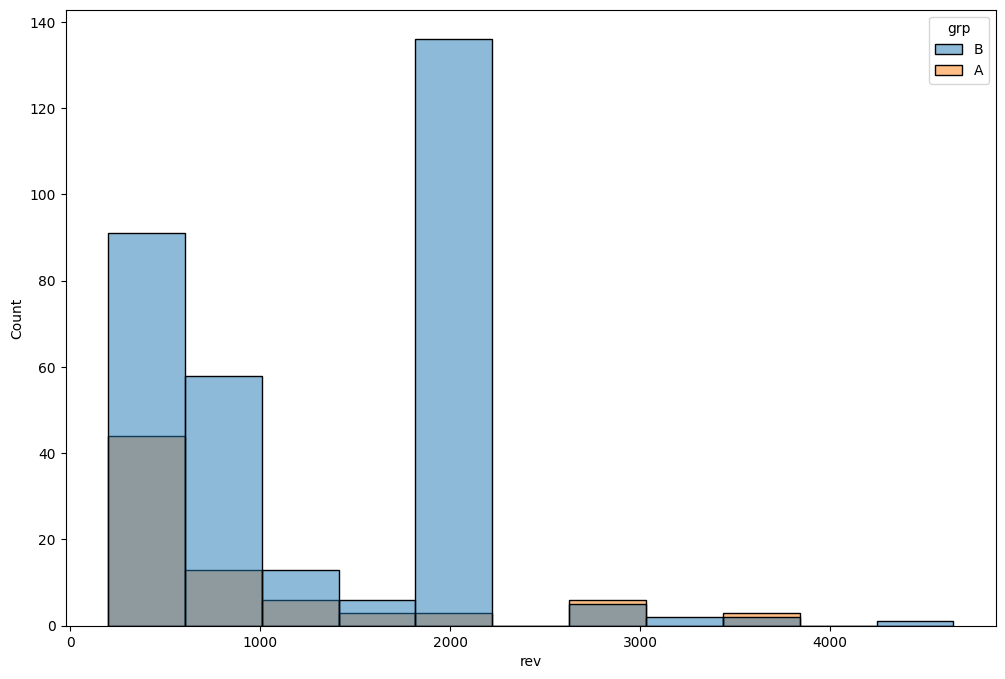

In [29]:
plt.figure(figsize=(12, 8))
sns.histplot(data = data, x = "rev", hue = "grp")

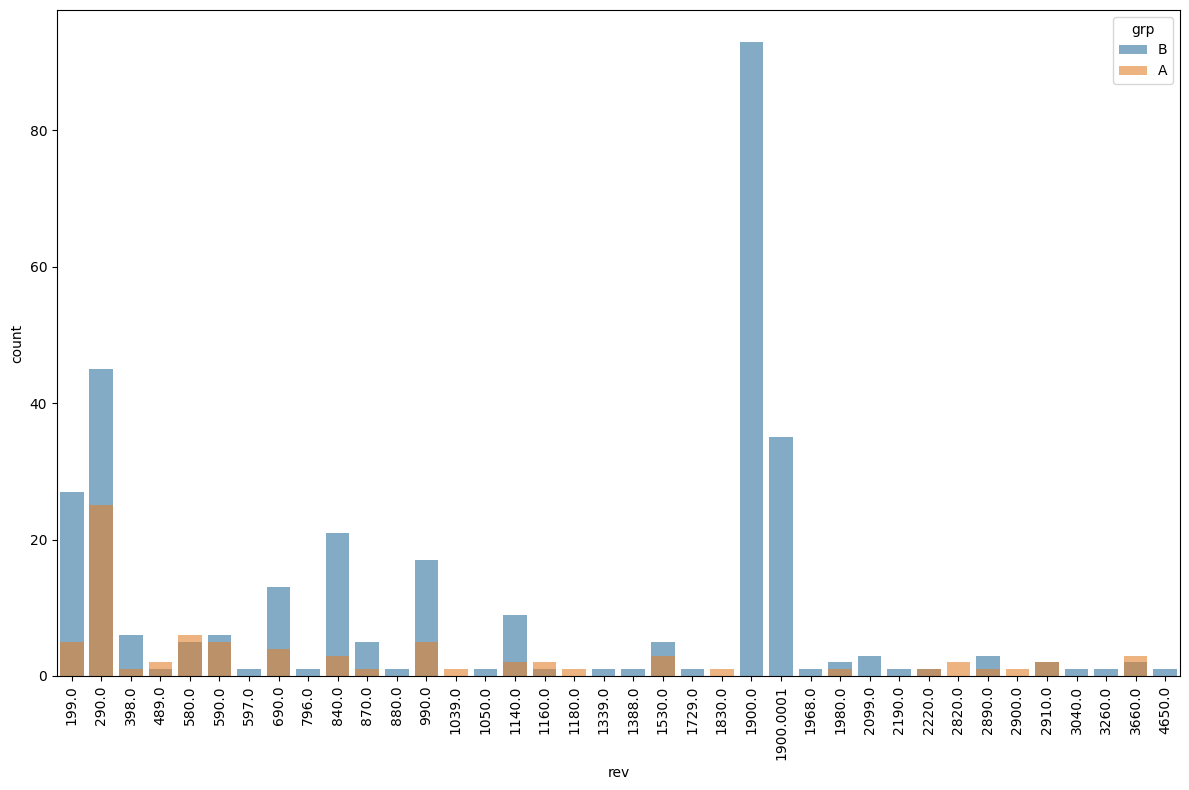

In [30]:
plt.figure(figsize=(12, 8))

data_sorted = data.sort_values("rev")

sns.countplot(
    data=data_sorted,
    x="rev",
    hue="grp",
    dodge=False,
    alpha=0.6
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Group B shows more larger payments, which may suggest that the new flow makes it easier to complete higher-value transactions.
<br>The distributions don't look normal, so we'll test this formally and compare the variances.

#### Normality:

We'll test the normality of the distributions using the Shapiro-Wilk test:

H₀: The sample comes from a normal distribution
<br>H₁: The sample does not come from a normal distribution

Significance level: 0.05

In [ ]:
!pip install pingouin

In [32]:
import pingouin as pg

In [33]:
pg.normality(data[data["rev"].notna()], dv="rev", group="grp", method='shapiro', alpha=0.05)


,W,pval,normal
grp,,,
A,0.735324,1.498692e-10,False
B,0.854722,1.543336e-16,False


Distributions are not normal

#### Equality of Variances

We'll check variance equality using **Levene's test**:

* **H₀:** Variances are equal
* **H₁:** Variances are not equal
* Significance level: 0.05


In [34]:
data.groupby("grp")["rev"].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


In [35]:
pg.homoscedasticity(data[data["rev"].notna()], dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


Fail to regect H0, assume variances are equal.

#### Test

In summary:

* The distributions are not normal
* The variances are equal
* The sample sizes differ
* Group B has many values around 1900, which we don't see in Group A

We'll compare the means using **Welch's t-test.**
Although the data are non-normal, the large sample size compensates for it, and Welch's test adjusts for unequal sample sizes.

<br>**Hypotheses:**

H₀: Mean(ARPPU(A)) = Mean(ARPPU(B))

H₁: Means are not equal

Significance level: 0.05

In [36]:
data_A = data.loc[data["grp"] == "A","rev"].dropna()
data_B = data.loc[data["grp"] == "B","rev"].dropna()
pg.ttest(data_A.values, data_B.values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


p-value < 0.05, so we reject the null hypothesis. **There is a statistically significant differecne between groups in ARPPU.**

### ARPAU
$$
ARPAU = \frac{\text{Total Revenue}}{\text{Count of Active Users}}
$$

In [37]:
data_active = data[data["active"]].copy()

In [38]:
data_active["rev"] = data_active["rev"].fillna(0)
data_active.head(10)

,id,grp,active,rev
1,1627,A,True,990.0
10,2085,B,True,0.0
12,2215,B,True,0.0
43,3391,A,True,0.0
45,3401,B,True,0.0
112,22994,B,True,0.0
159,26899,B,True,0.0
161,27079,B,True,0.0
179,29021,B,True,0.0
208,98633,B,True,0.0


In [39]:
data_active.groupby("grp")["rev"].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


Let's see the distribution by groups

<Axes: xlabel='rev', ylabel='Count'>

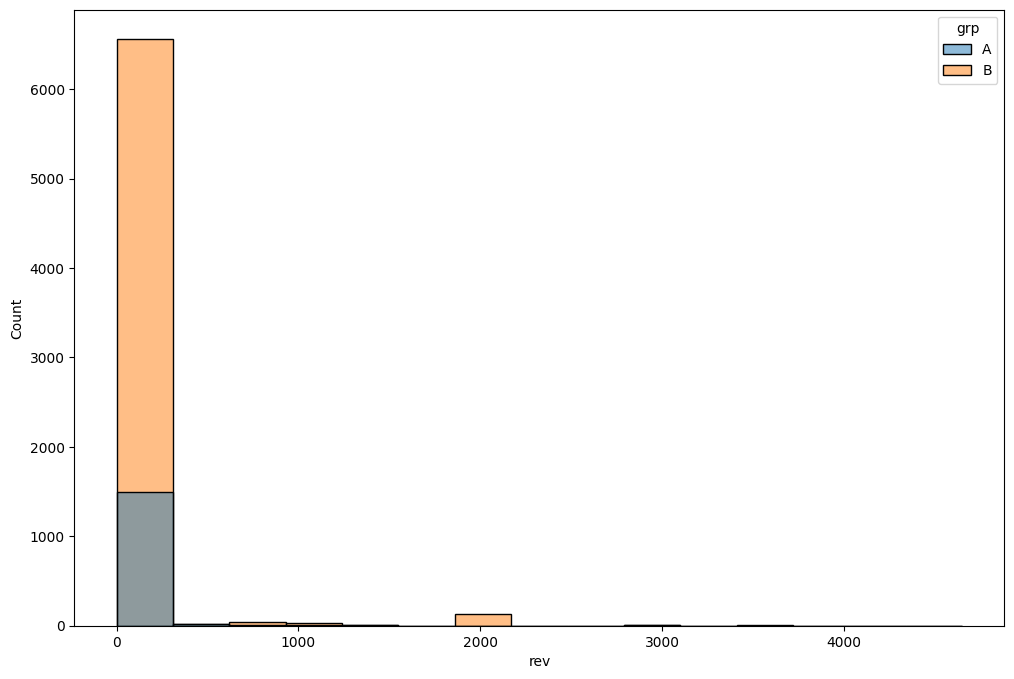

In [40]:
plt.figure(figsize=(12, 8))
sns.histplot(data = data_active, x = "rev", hue = "grp")

####Normality

The ARPAU distribution is heavily right-skewed: most users have zero revenue, while a small group has much higher values.
Formal tests like Shapiro-Wilk lose practical meaning with large samples (>5000), as they flag even minor deviations from normality.
So instead, we'll assess the distribution visually using a Q-Q plot and a histogram.


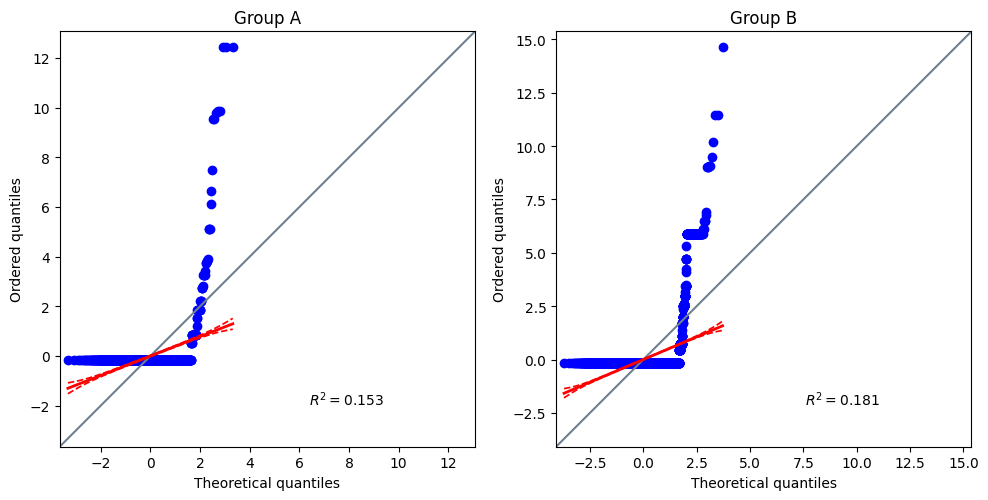

In [41]:
data_active_A = data_active.loc[data_active["grp"]=="A","rev"]
data_active_B = data_active.loc[data_active["grp"] == "B","rev"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

pg.qqplot(data_active_A, ax=axes[0])
axes[0].set_title("Group A")

pg.qqplot(data_active_B, ax=axes[1])
axes[1].set_title("Group B")

plt.tight_layout()

Since the ARPAU distribution is far from normal, we’ll use bootstrapping to estimate the confidence interval for the difference in mean ARPU between the groups.

#### Test

We'll use the bootstrap method to compare the means.
<br>H₀: ARPAU(A)- ARPAU(B) = 0
<br>H₁: The difference in means is not equal to zero
CI = 95%

In [55]:
from scipy.stats import bootstrap

data_active_A = data_active.loc[data_active["grp"]=="A","rev"]
data_active_B = data_active.loc[data_active["grp"] == "B","rev"]


def mean_difference(data1, data2, axis=None):
    return np.mean(data1, axis = axis) - np.mean(data2, axis = axis)

res = bootstrap((data_active_A,data_active_B), mean_difference, method='basic', n_resamples = 10000)

print(f"Group A mean: {np.mean(data_active_A):.2f}")
print(f"Group B mean: {np.mean(data_active_B):.2f}")
print(f"Observed difference {mean_difference(data_active_A, data_active_B):.2f}")
print(f"Bootstrap 95% Conficence Inreval: ({round(res.confidence_interval.low,2)}, {round(res.confidence_interval.high,2)})")

Group A mean: 47.35
Group B mean: 58.06
Observed difference -10.71
Bootstrap 95% Conficence Inreval: (-27.77, 5.37)


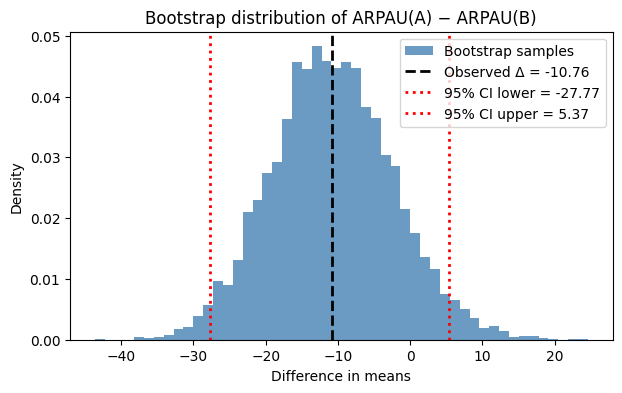

In [58]:
import matplotlib.pyplot as plt
import numpy as np

diffs = res.bootstrap_distribution
lo, hi = res.confidence_interval
point = np.mean(diffs)

plt.figure(figsize=(7,4))
plt.hist(diffs, bins=50, density=True, color="steelblue", alpha=0.8, label="Bootstrap samples")
plt.axvline(point, color="black", linestyle="--", linewidth=2, label=f"Observed Δ = {point:.2f}")
plt.axvline(lo, color="red", linestyle=":", linewidth=2, label=f"95% CI lower = {lo:.2f}")
plt.axvline(hi, color="red", linestyle=":", linewidth=2, label=f"95% CI upper = {hi:.2f}")

plt.title("Bootstrap distribution of ARPAU(A) − ARPAU(B)")
plt.xlabel("Difference in means")
plt.ylabel("Density")
plt.legend()
plt.show()



The confidence interval includes zero, so we **fail to reject the null hypothesis.**

In [64]:
def plot_metrics(df):
    metrics = ['CR', 'ARPPU', 'ARPU']
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, metric in enumerate(metrics):
        sns.barplot(data=df, x='group', y=metric, hue = 'group', ax=axes[i])
        axes[i].set_title(metric)
        axes[i].set_xlabel('Группа')


    plt.tight_layout()
    plt.show()


##Analysis Summary

The A/B test results for the new payment flow were analyzed.
<br>A total of **74,576** users took part in the experiment (control/test ≈ 20/80).
**8,341** users were active on the platform, and **541** of them made a payment.
**149** inactive users were excluded, as the change couldn’t have affected them.
All metrics were calculated based on active users.

Results:

In [59]:
data_pivot

,group,assigned_users,active_users,paying_users,rev_total,ARPPU,CR,ARPU
0,A,14664,1538,78,72820.0000,933.589744,0.050715,47.347204
1,B,59763,6803,314,394974.0035,1257.878992,0.046156,58.058798


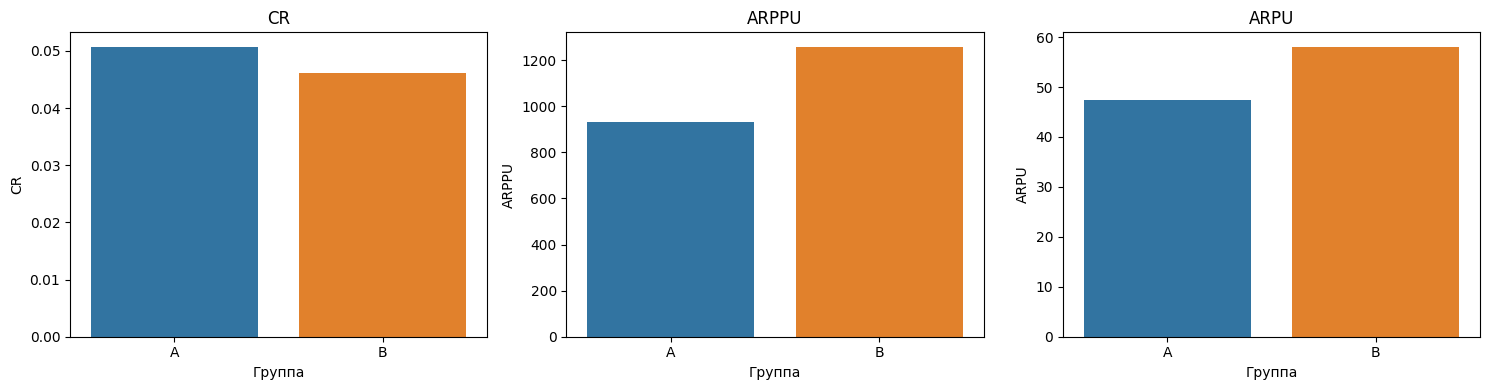

In [65]:
plot_metrics(data_pivot)

| Metric    | Result              | Test / Method                             | Interpretation                            |
| :-------- | :------------------ | :---------------------------------------- | :---------------------------------------- |
| **CR**    | 5.07% to 4.62%       | z-test for proportions                    | No significant difference, p > 0.05       |
| **ARPPU** | from 933 to 1,258 | Welch's t-test                            | Average payment increased, p < 0.05       |
| **ARPU**  | from 47.3 to 58.1 | Bootstrap diff = -10.7 (95% CI = -27.8; 5.4) | CI includes 0, no significant difference |


<br>

 **Interpretation**

The new payment flow increased the average check (ARPPU) but slightly reduced the conversion rate (CR).
Overall revenue per active user (ARPU) showed no statistically significant change.

The increase in ARPPU is mainly due to a higher share of purchases at the 1,900 price point.

---

### Conclusion

The new payment flow did not improve overall financial performance, the rise in average check was offset by the drop in conversion.
